# Final Project: Product Image Enhancement

### Env setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
datadir = "/content/drive/My Drive/Colab Notebooks/ComputationalPhotography/Comp_Photo_Final/"
!cp -r "$datadir" .

In [ ]:
# !pip install opencv-python matplotlib numpy rembg onnxruntime
!python3.11 -m pip install rembg onnxruntime scipy

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
import scipy
from PIL import Image

## Setup

In [4]:
def get_foreground_mask(image_rgb):
    result_rgba = remove(image_rgb)
    alpha = result_rgba[:, :, 3]
    return (alpha > 127).astype(np.uint8)  # Binary mask

def feather_mask(mask, feather_radius=15):
    blurred_mask = cv2.GaussianBlur(mask.astype(np.float32), (0, 0), feather_radius)
    return np.clip(blurred_mask, 0, 1)[..., None]  # Shape: (H, W, 1)

def get_mask_for_rgb(mask):
    return mask[...,None] # Shape: (H,W,1)

def blur_background(img, mask, ksize=101):
    blurred = cv2.GaussianBlur(img, (ksize, ksize), 0)
    mask_rgb = get_mask_for_rgb(mask)
    return (mask_rgb * img + (1 - mask_rgb) * blurred).astype(np.uint8)

def white_background(image, mask):
    white = np.ones_like(image, dtype=np.uint8) * 255
    mask_rgb = get_mask_for_rgb(mask)
    return (mask_rgb * image + (1 - mask_rgb) * white).astype(np.uint8)

def display_setup_images(original_rgb, blurred_output, white_output, mask):
    plt.figure(figsize=(16, 8))
    
    titles = ["Original", "Blurred Background", "White Background", "Mask"]
    images = [original_rgb, blurred_output, white_output, mask]
    n = len(titles)
    
    for i in range(n):
        plt.subplot(1, n, i+1)
        if titles[i] == "Mask":
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Gradient Domain Enhancement

In [5]:
def compute_gradients(img):
    dx = np.zeros_like(img)
    dy = np.zeros_like(img)
    dx[:, :-1] = img[:, 1:] - img[:, :-1]
    dy[:-1, :] = img[1:, :] - img[:-1, :]
    return dx, dy

def enhance_highfreq_gradients(img, sigma=5, alpha=1.5):
    # get high frequencies
    img_blur = cv2.GaussianBlur(img, (0, 0), sigma)
    high_frequency = img - img_blur

    # compute gradients
    dx, dy = compute_gradients(high_frequency)

    # amplify high-frequency gradients
    dx_enh = dx * alpha
    dy_enh = dy * alpha

    return dx_enh, dy_enh, img_blur

def get_gradient_diff(dx, dy):
    # compute difference of gradients
    div = np.zeros_like(dx)
    div[:, :-1] += dx[:, :-1]
    div[:, 1:] -= dx[:, :-1]
    div[:-1, :] += dy[:-1, :]
    div[1:, :] -= dy[:-1, :]
    return div

def get_A(h, w):
    N = h * w
    A = scipy.sparse.lil_matrix((N, N), dtype=np.float32)

    im2var = np.arange(N).reshape(h, w)

    for y in range(h):
        for x in range(w):
            e = im2var[y,x]

            if x == 0 and y == 0:
                A[e,e] = -2
            elif x == w-1 and y == h-1:
                A[e,e] = -2
            elif x == 0 or x == w-1:
                A[e,e] = -3
            elif y == 0 or y == h-1:
                A[e,e] = -3
            else:
                A[e,e] = -4

            if x > 0:
                A[e, im2var[y,x-1]] = 1
            if x < w - 1:
                A[e, im2var[y,x+1]] = 1
            if y > 0:
                A[e, im2var[y-1,x]] = 1
            if y < h - 1:
                A[e, im2var[y+1,x]] = 1

    return A.tocsr()

def poisson_solve(enh_grad_div, img_orig):
    h, w = enh_grad_div.shape
    A = get_A(h,w)
    b = enh_grad_div.flatten()

    # set boundary to original image
    b_boundary = img_orig.copy()
    b_boundary[1:-1, 1:-1] = 0
    dx, dy = compute_gradients(b_boundary)
    b += get_gradient_diff(dx, dy).flatten()

    # solve lsqr
    x = scipy.sparse.linalg.lsqr(A, b)[0]
    x = x.reshape((h, w))
    return x

# NOTE: this takes a while on images that are large
def get_gradient_domain_contrast_enhancement(original_rgb_img, mask):
    blurred_output = blur_background(original_rgb_img, mask, ksize=51)

    img_rgb = original_rgb_img.astype(np.float32)

    final_result = np.zeros(img_rgb.shape)

    for c in range(3):
        # enhance only high-frequency gradients
        dx_enh, dy_enh, img_blur = enhance_highfreq_gradients(img_rgb[:,:,c], sigma=5, alpha=1.5)

        # compute difference of enhanced gradients
        enh_grad_diff = get_gradient_diff(dx_enh, dy_enh)

        # solve Poisson equation on high-frequencies
        reconstructed = poisson_solve(enh_grad_diff, img_rgb[:,:,c])

        # add back the low-frequency background
        final_result[:,:,c] = reconstructed + blurred_output[:,:,c]

    # clip to valid range
    final_result = np.clip(final_result, 0, 255).astype(np.uint8)

    return final_result

## White Balance and Tone Mapping

In [6]:
def white_balance_and_tone_mapping(img_rgb):
    img = img_rgb / 255.0
    # Average all the color channels
    red_avg, green_avg, blue_avg = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    avg = (red_avg + green_avg + blue_avg) / 3.0
    # Find the maximum color skew
    color_cast = max([abs(red_avg - avg), abs(green_avg - avg), abs(blue_avg - avg)])
    
    # Adjust white balance if there is a color cast (strong color deviation in one or more channels)
    if color_cast > 0.02:
        white_balance_strength = min(color_cast / avg, 0.4)
        img[:,:,0] *= 1.0 + white_balance_strength * ((avg - red_avg) / (red_avg + 1e-6))
        img[:,:,1] *= 1.0 + white_balance_strength * ((avg - green_avg) / (green_avg + 1e-6))
        img[:,:,2] *= 1.0 + white_balance_strength * ((avg - blue_avg) / (blue_avg + 1e-6))
        img = np.clip(img, 0, 1)
    
    # adjust the brightness in the LAB color space
    img_lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l_channel = img_lab[:,:,0].astype(np.float32) / 255.0
    
    # normalize l channel
    low_percentile, high_percentile = np.percentile(l_channel, (1, 99))
    l_channel = np.clip((l_channel - low_percentile)/ (high_percentile - low_percentile +1e-6), 0, 1)
    
    # bring down highlights if more than 2% of the image is too bright
    if np.mean(l_channel > 0.95) > 0.02:
        l_channel[l_channel > 0.95] = 0.95 + 0.5 * (l_channel[l_channel > 0.95] - 0.95)
    # boost shadows if more than 5% of the image is very dark
    if np.mean(l_channel < 0.1) > 0.05:
        l_channel[l_channel < 0.1] = np.power(l_channel[l_channel < 0.1], 0.8)
    
    # brighten the entire image slightly
    l_channel = np.power(l_channel, 0.95)
    
    # boost contrast in the midtones
    l_channel = 0.5 + 1.1 * (l_channel - 0.5)
    l_channel = np.clip(l_channel, 0, 1)
    
    img_lab[:,:,0] = np.clip(l_channel * 255, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    return img

## Background Removal

### Background Removal: Background Segmentation Method

In [7]:
def rm_background_segmentation(img):
    # rembg background removal on image, rembg trained on single objects
    fg_rgba = remove(Image.fromarray(img))
    fg_rgba = np.array(fg_rgba)

    return fg_rgba

### Background Removal: Grabcut Method

In [8]:
# Grabcut, needs bounding box and contrast between object, bad w/ mug
def build_bounding_rect(img):
    H,W,C = img.shape
    
    init_mask = get_foreground_mask(img)
    ys, xs = np.nonzero(init_mask)

    # Get bounding box of the mask with buffer
    ymin = np.min(ys) - 10
    ymax = np.max(ys) - 10
    xmin = np.min(xs) - 10
    xmax = np.max(xs) - 10

    if ymin < 0:
        ymin = 0
    if xmin < 0:
        xmin = 0
    if ymax < 0:
        ymax = 0
    if xmax < 0:
        xmax = 0

    w = xmax - xmin + 1 + 20
    h = ymax - ymin + 1 + 20

    if (xmin + w) >= W:
        w = W - xmin - 1
    if (ymin + h) >= H:
        h = H - ymin - 1

    # why isn't the xmin right???
    rect = (xmin, ymin, w, h)
    return rect
    

def rm_background_grabcut(img):
    mask = np.ones(img.shape[:2], np.uint8)
    w, h, _ = img.shape
    
    rect = build_bounding_rect(img)
    
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    
    # Run GrabCut
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Create binary mask
    binary_mask = np.where((mask==2)|(mask==0), 0, 1).astype(np.uint8)
    result = img * binary_mask[:, :, np.newaxis]

    return binary_mask, result

In [9]:
def get_combo_mask(mask_rembg, mask_gc):
    return (mask_rembg & mask_gc).astype(int)

def get_masked_img(img, mask):
    return img * mask[:, :, np.newaxis]

## Add Shadow

In [10]:
def add_shadow(img, mask):
    # Create the shadow base from the mask
    shadow = mask.copy()
    
    # Ensure shape is available
    h, w = shadow.shape[:2]

    src_pts = np.float32([[0,0], [w,0], [0,h], [w,h]])
    dst_pts = np.float32([  # note: dst_pts was found through experimentation
        [0, h*0.3], 
        [w*0.6, h*0.3], 
        [0,h], 
        [w, h*0.95]
    ])
    
    # Compute perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    # Warp the mask to create the shadow shape
    shadow_warped = cv2.warpPerspective(shadow.astype(np.float32), M.astype(np.float32), (w, h))
    
    # Convert to 3 channels and apply blur
    shadow_blur = cv2.GaussianBlur(shadow_warped, (51, 51), 0)
    shadow_bgr = cv2.merge([shadow_blur]*3)
    
    # Tint shadow to black and reduce intensity
    shadow_final = (shadow_bgr * 0.4).astype(np.float32)
    
    # Prepare white background
    background = np.ones_like(img)

    # Place shadow and then object
    shadow = ((background - shadow_final) * 255.0).astype(np.uint8)

    return (get_mask_for_rgb(mask) * img) + (get_mask_for_rgb(1-mask) * shadow)


## Combine Parts

In [11]:
def enhance_product_image(input_path):
    original_image = cv2.imread(input_path)
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # setup
    mask = get_foreground_mask(original_rgb)
    blurred_background = blur_background(original_rgb, mask, ksize=51)
    white_output = white_background(original_rgb, mask)

    # UNCOMMENT to display setup images
    # display_setup_images(original_rgb, blurred_background, white_output, mask)
    
    # gradient domain enhancement
    gdce_img = get_gradient_domain_contrast_enhancement(original_rgb, mask)
    
    # white balance and tone mapping
    wbatm_img = white_balance_and_tone_mapping(gdce_img)
    
    # background removal
    segmentation_img = rm_background_segmentation(wbatm_img)
    mask_gc, gc_img = rm_background_grabcut(wbatm_img)
    
    # UNCOMMENT to display intermediate steps results
    # plt.figure(figsize=(16, 8))
    # titles = ["Original", "+ gradient domain enhancement", "+ white balance and tone mapping", "+ background removal"]
    # images = [original_rgb.astype(np.uint8), gdce_img, wbatm_img, gc_img]
    # for i in range(4):
    #     plt.subplot(1, 4, i+1)
    #     plt.imshow(images[i])
    #     plt.title(titles[i])
    #     plt.axis("off")
    # plt.tight_layout()
    # plt.show()
    
    combo_mask = get_combo_mask(mask, mask_gc)
    final_result = white_background(segmentation_img, combo_mask)
    final_result_w_shadow = add_shadow(final_result[:,:,:-1], combo_mask)

    # display final results
    plt.figure(figsize=(16, 8))
    titles = ["Original", "Final Result"]
    images = [original_rgb.astype(np.uint8), final_result_w_shadow]
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    return cv2.cvtColor(final_result_w_shadow.astype(np.uint8), cv2.COLOR_RGB2BGR)


## Display Test Image Results

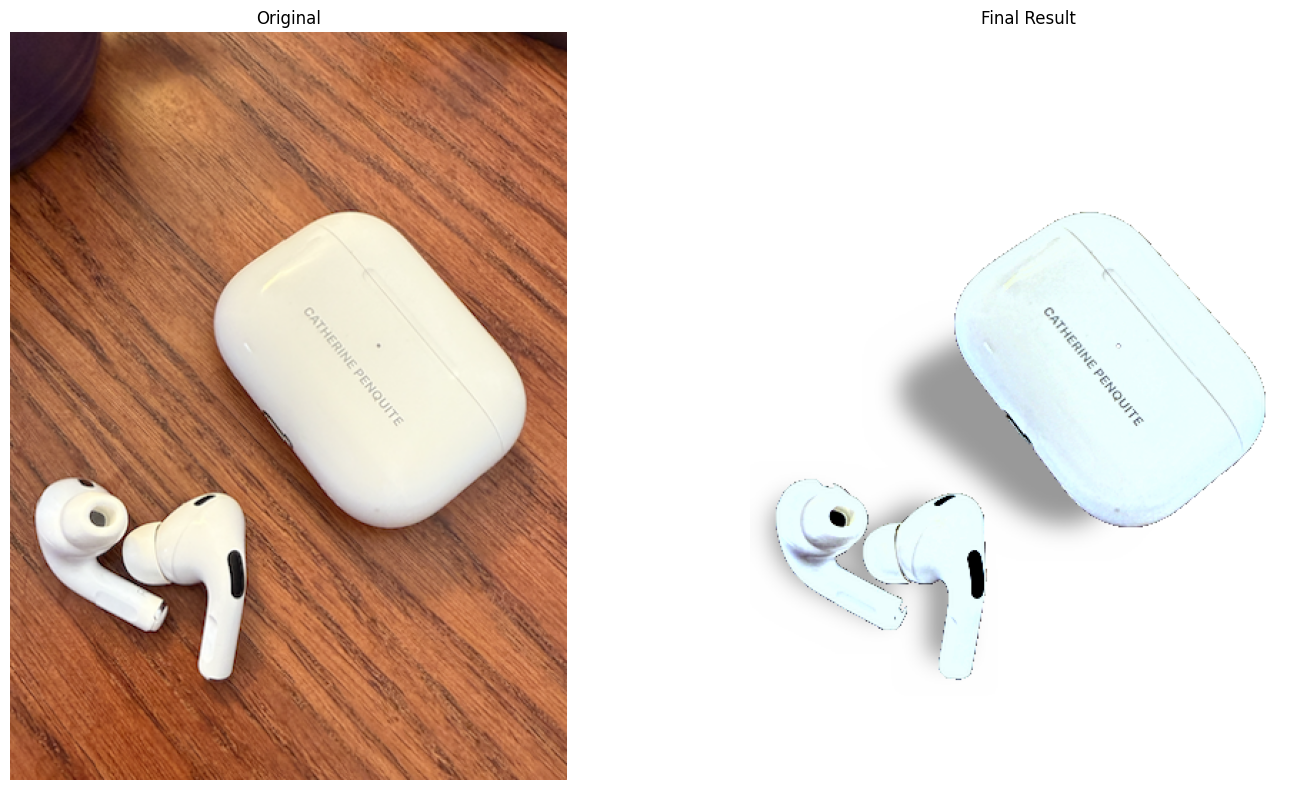

True

In [14]:
input_path = "images/airpods_small.png"

airpods_result = enhance_product_image(input_path)

# Save
cv2.imwrite("results/airpods_small.png", airpods_result)

## Online Results

### Poshmark Example
https://poshmark.com/listing/Under-Armour-Sweatshirt-6692b949280cc66d046f4cea

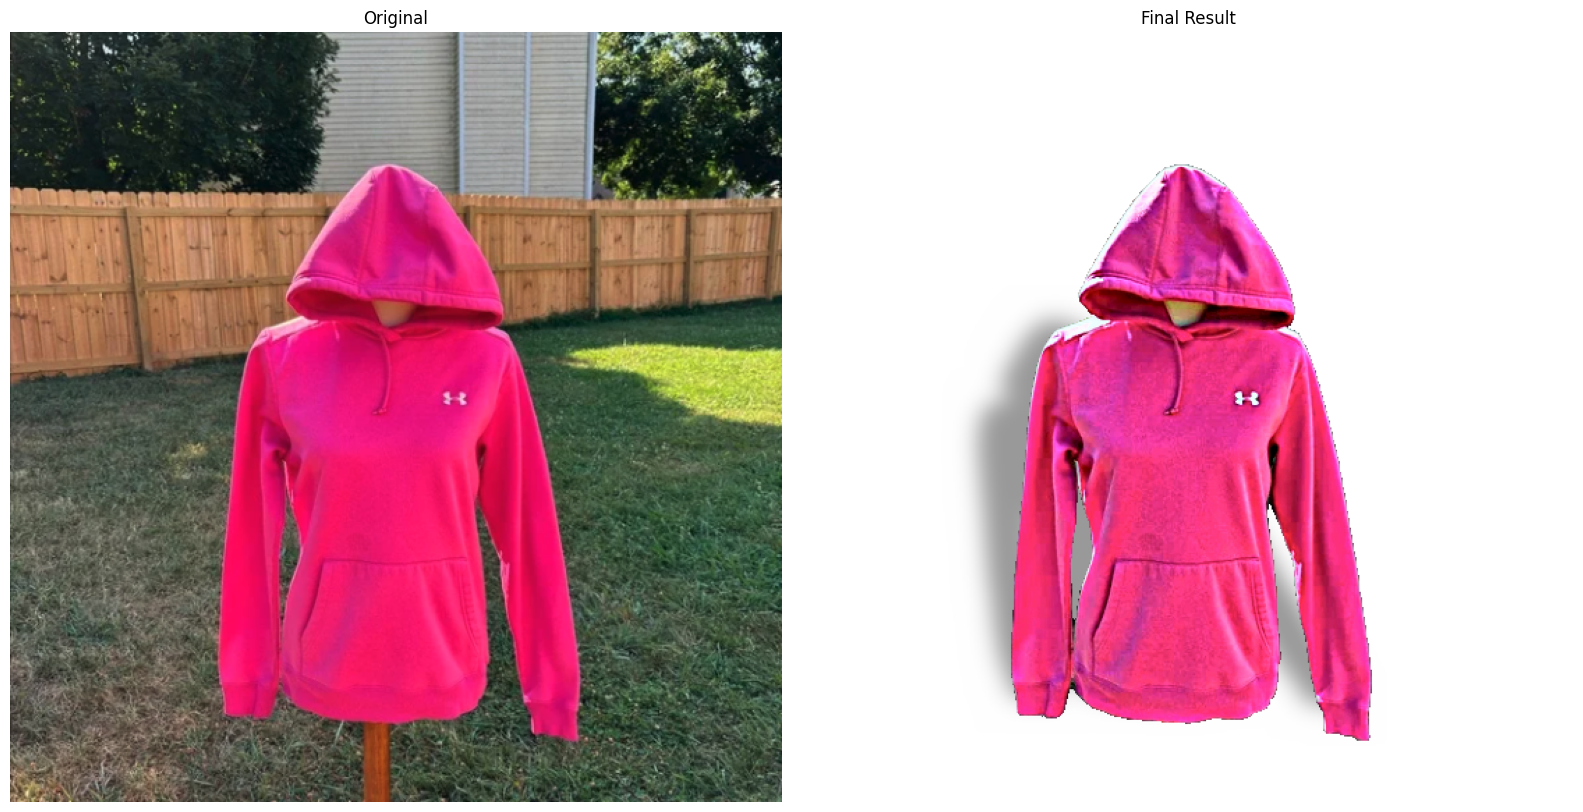

True

In [15]:
input_path = "images/poshmark.png"

# NOTE: sometimes the grabcut algorithm doesn't remove the pole at the bottom - rerun in this case
poshmark_result = enhance_product_image(input_path)

# Save
cv2.imwrite("results/poshmark.jpg", poshmark_result)

### Ebay Example
https://www.ebay.com/itm/356779514466

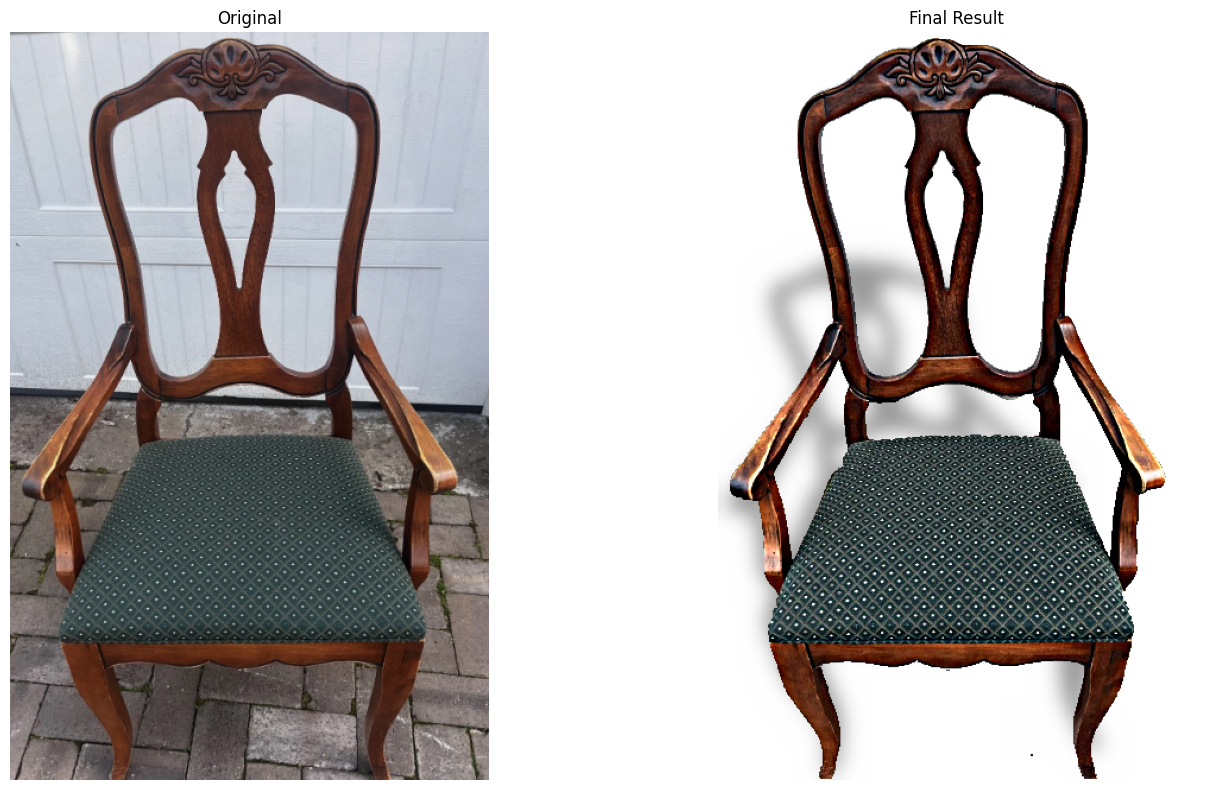

True

In [16]:
input_path = "images/ebay.png"

# NOTE: sometimes the grabcut algorithm doesn't remove as much of the ground as usual - rerun in this case
ebay_result = enhance_product_image(input_path)

# Save
cv2.imwrite("results/ebay.jpg", ebay_result)

## Etsy Example
https://www.etsy.com/listing/1815771372/crochet-mini-loaf-cat-plush-amigurumi?ls=s&ga_order=most_relevant&ga_search_type=all&ga_view_type=gallery&ga_search_query=knited+cat&pop=1&sts=1&content_source=909d997da6b75e6471910df9e005814e268b63e2%253A1815771372&search_preloaded_img=1&organic_search_click=1&logging_key=909d997da6b75e6471910df9e005814e268b63e2:1815771372

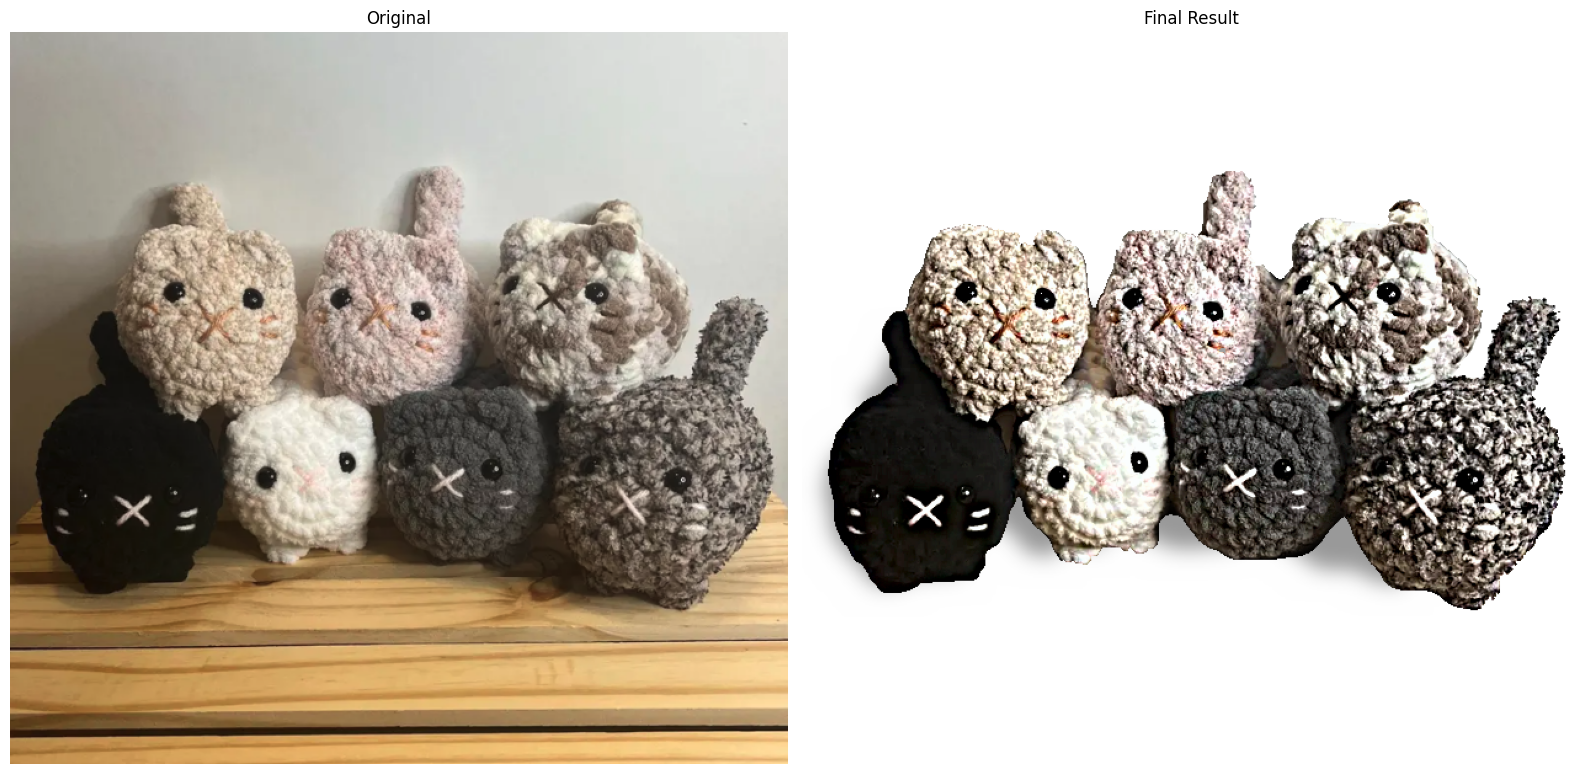

True

In [17]:
input_path = "images/etsy.png"

etsy_result = enhance_product_image(input_path)

# Save
cv2.imwrite("results/etsy.jpg", etsy_result)